In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

from tqdm import tqdm
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Bidirectional, Dropout, BatchNormalization, GRU
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from Functions._createModel import *
from Functions._analyzeData import *
from Functions._editDatabase import getTransactionData, getAccount

plt.style.use("fivethirtyeight")

In [37]:
df = getTimeCycle(getTransactionData(getAccount("atlas")), "DAY", training=True)

budget = df["TOTAL"].cumsum()
budget.index = pd.to_datetime(df.index)
budget = budget.to_frame(name='TOTAL')
budget = addFeatures(budget)

expenses = df[("Expenses", "TOTAL")].cumsum()
revenue = np.array(df[("Revenue", "TOTAL")].cumsum())

budget = budget.rename(columns={"TOTAL": "Budget"})

df = budget

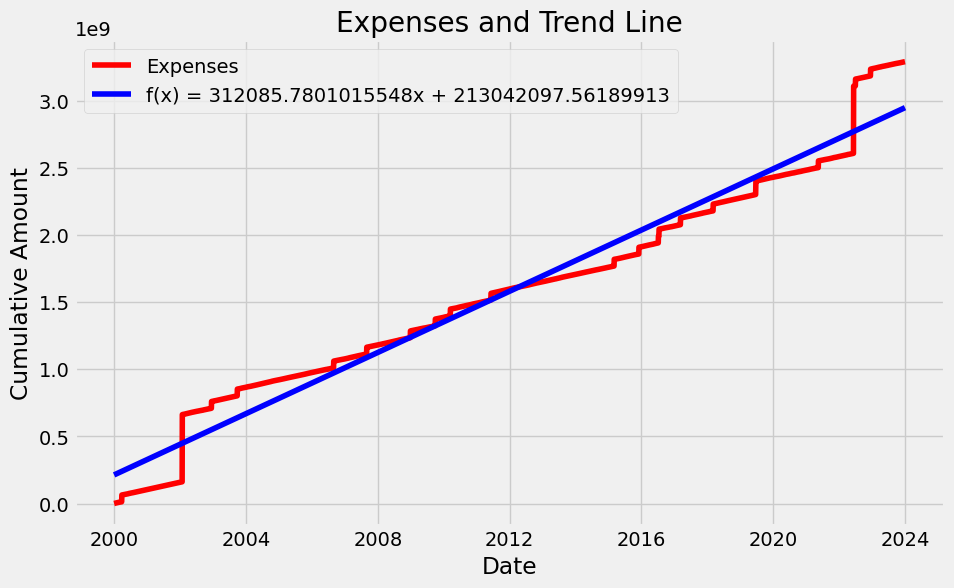

In [40]:
m, b = np.polyfit(np.arange(len(expenses)), expenses, 1)

x = np.arange(len(df))
y = m * x + b

y = pd.DataFrame(y, index=df.index, columns=['Trend Line'])

plt.figure(figsize=(10, 6))
plt.plot(df.index, expenses, label='Expenses', color='red')
plt.plot(y.index, y, label=f'f(x) = {m}x + {b}', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Amount')
plt.title('Expenses and Trend Line')
plt.legend()
plt.show()

In [3]:
# Create Features
def create_features(df):
    df["Hour"] = df.index.hour
    df["DoW"] = df.index.day_of_week
    df["Quarter"] = df.index.quarter
    df["Month"] = df.index.month
    df["Year"] = df.index.year
    df["DoY"] = df.index.day_of_year
    return df

df = create_features(df)

df

,Budget,Hour,DoW,Quarter,Month,Year,DoY
DAY,,,,,,,
2000-01-01,-168000.0,0,5,1,1,2000,1
2000-01-02,-248000.0,0,6,1,1,2000,2
2000-01-03,-480000.0,0,0,1,1,2000,3
2000-01-04,-620000.0,0,1,1,1,2000,4
2000-01-05,-752000.0,0,2,1,1,2000,5
...,...,...,...,...,...,...,...
2023-12-26,178941000.0,0,1,4,12,2023,360
2023-12-27,178835000.0,0,2,4,12,2023,361
2023-12-28,178701000.0,0,3,4,12,2023,362


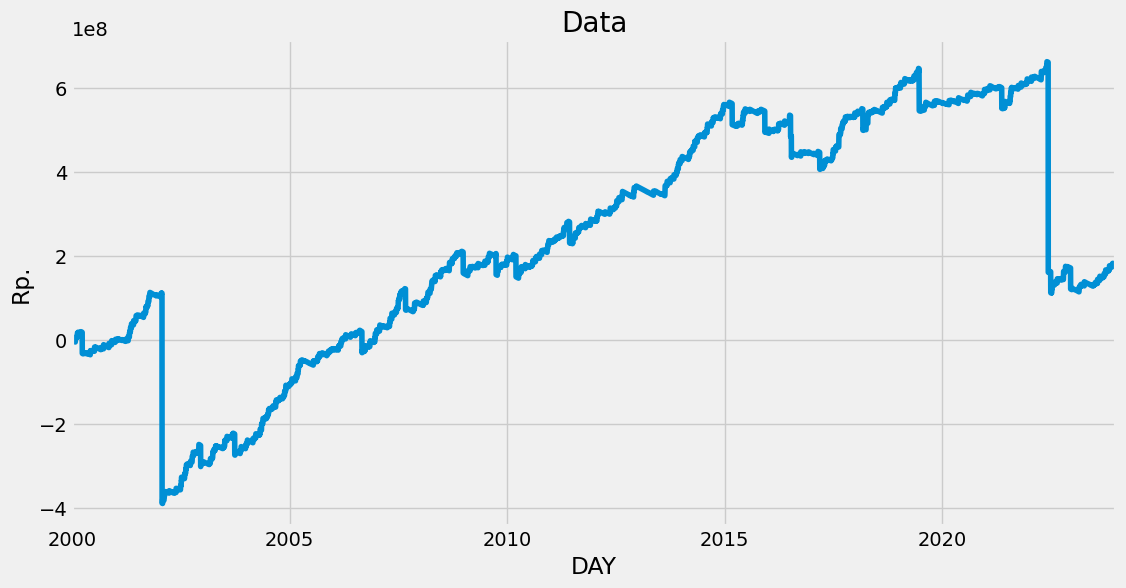

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
df["Budget"].plot(title="Data")
plt.ylabel("Rp.")
plt.grid(True)
plt.show()

          Train Size : 7888
     Validation Size : 438
           Test Size : 8765


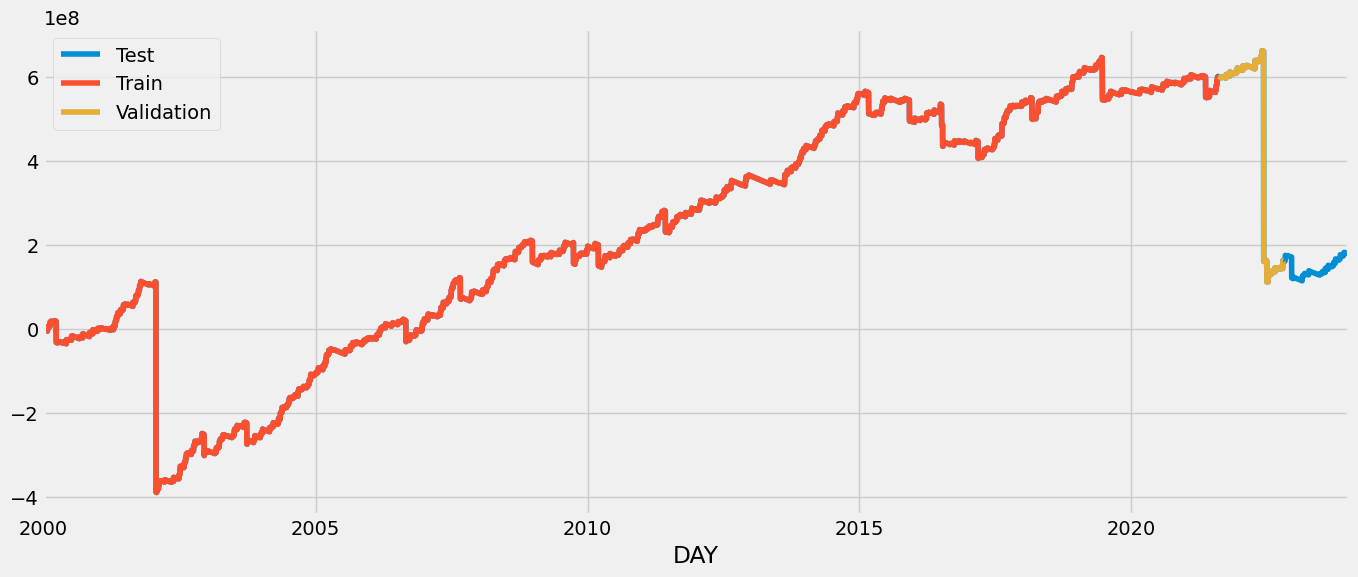

In [5]:
# Features and Target

FEATURES = ["Hour", "DoW", "Quarter", "Month", "Year", "DoY"]
TARGET = ["Budget"]

# Split Data

data_length = len(df)
train_size = 0.9
val_size = 0.05
test_size = 0.05

train, temp = train_test_split(df, train_size=train_size, shuffle=False)
val, test = train_test_split(temp, test_size=test_size/(val_size + test_size), shuffle=False)

test = df

X_train = train[FEATURES]
y_train = train[TARGET]
X_val = val[FEATURES]
y_val = val[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]


print(f"{'Train Size':>20} : {len(train)}")
print(f"{'Validation Size':>20} : {len(val)}")
print(f"{'Test Size':>20} : {len(test)}")

fig, ax = plt.subplots(figsize=(15, 6))
test["Budget"].plot(ax=ax, label="Test")
train["Budget"].plot(ax=ax, label="Train")
val["Budget"].plot(ax=ax, label="Validation")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
train

,Budget,Hour,DoW,Quarter,Month,Year,DoY
DAY,,,,,,,
2000-01-01,-168000.0,0,5,1,1,2000,1
2000-01-02,-248000.0,0,6,1,1,2000,2
2000-01-03,-480000.0,0,0,1,1,2000,3
2000-01-04,-620000.0,0,1,1,1,2000,4
2000-01-05,-752000.0,0,2,1,1,2000,5
...,...,...,...,...,...,...,...
2021-08-01,598760000.0,0,6,3,8,2021,213
2021-08-02,598618000.0,0,0,3,8,2021,214
2021-08-03,598460000.0,0,1,3,8,2021,215


In [7]:
# Normalize data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Include Time Steps

X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [8]:
model = Sequential([
    Input(shape=(1, X_train_reshaped.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    Dense(25, activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dense(1)
])


In [9]:
model.compile(optimizer=Adam(learning_rate=0.5), loss="mae")

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 25)          │         3,225 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1, 1)           │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,471 (283.09 KB)

 Trainable params: 72,421 (282.89 KB)

 Non-trainable params: 50 (200.00 B)

In [10]:
history = model.fit(
    X_train_reshaped, y_train,
    epochs=300,
    batch_size=16,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=0.0001)
    ]
)

Epoch 1/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 298563648.0000 - val_loss: 468320960.0000 - learning_rate: 0.5000
Epoch 2/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 294058176.0000 - val_loss: 452023136.0000 - learning_rate: 0.5000
Epoch 3/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 284445184.0000 - val_loss: 419950976.0000 - learning_rate: 0.5000
Epoch 4/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 271926496.0000 - val_loss: 379006784.0000 - learning_rate: 0.5000
Epoch 5/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 243288640.0000 - val_loss: 338622720.0000 - learning_rate: 0.5000
Epoch 6/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 221079968.0000 - val_loss: 322447232.0000 - learning_rate: 0.5000
Epoch 7/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 196415744.0000 - val_loss: 297876480.0000 - learning_rate: 0.5000
Epoch 8/300
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 170823760.0000 - val_loss: 270279776.0000 - learni

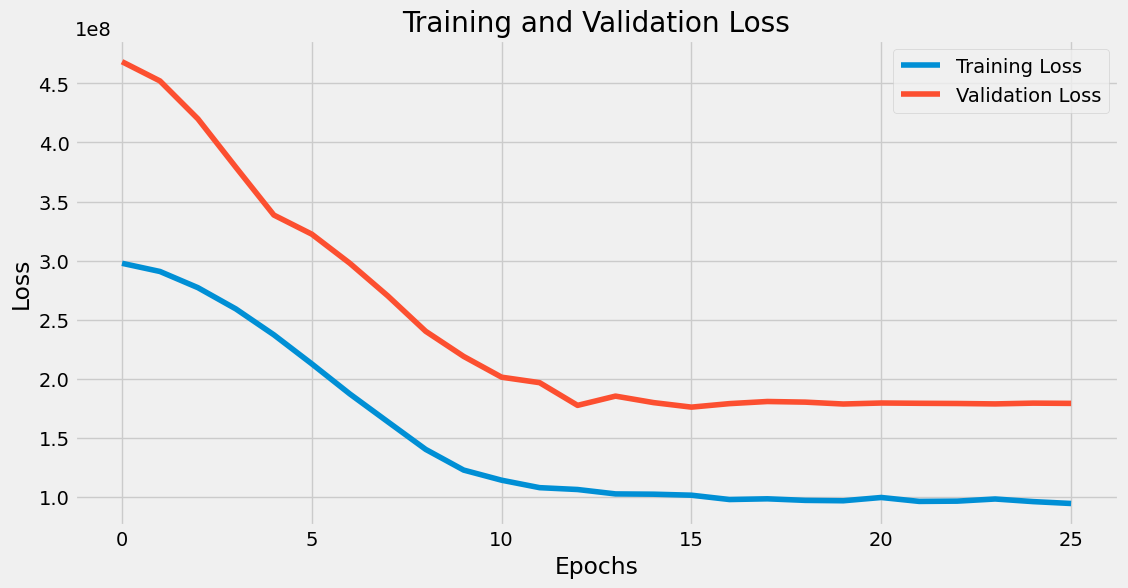

In [11]:
# Graph History

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(12, 6))
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [12]:
# Model Performance

predictions = model.predict(X_test_reshaped)
predictions = predictions.flatten()
test["Prediction"] = predictions

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


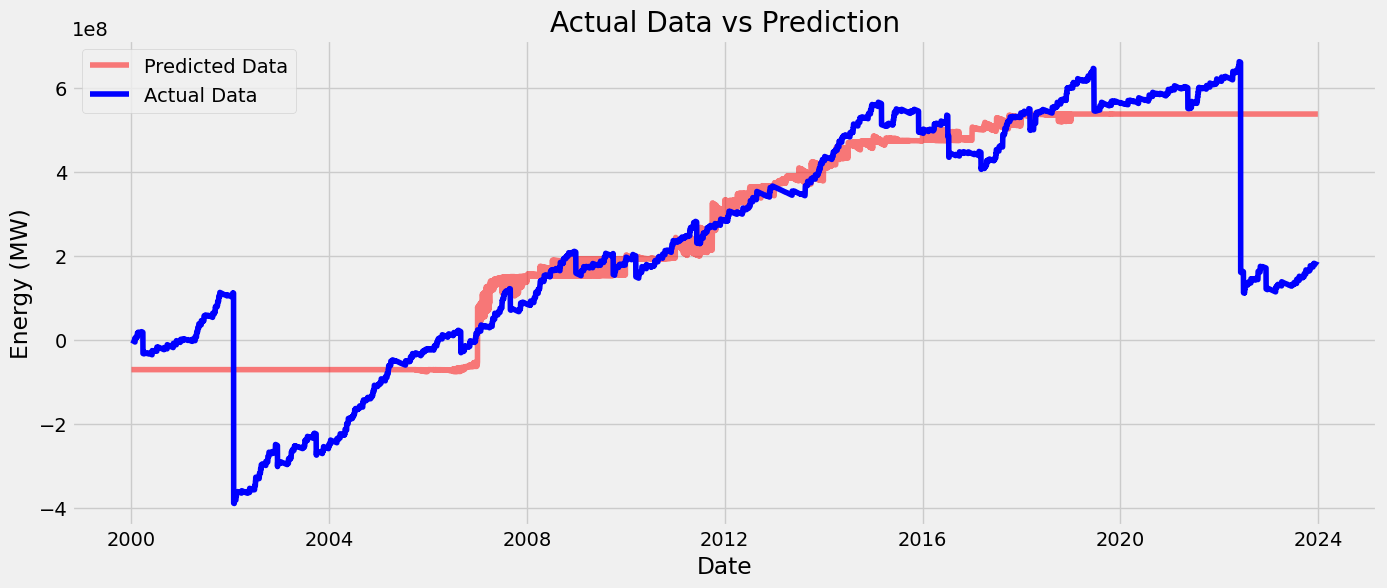

In [13]:
plt.figure(figsize=(15, 6))
plt.plot(test["Prediction"], label="Predicted Data", alpha=0.5, color='red')
plt.plot(df["Budget"], label="Actual Data", color='blue')
plt.xlabel("Date")
plt.ylabel("Energy (MW)")
plt.title("Actual Data vs Prediction")
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# Performance Evaluation

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mse)
mape = np.mean(np.abs((np.array(y_test) - np.array(predictions)) / np.array(y_test))) * 100

print(f"{'MSE':>6} : {mse:>7.4f}")
print(f"{'MAE':>6} : {mae:>7.4f}")
print(f"{'RMSE':>6} : {rmse:>7.4f}")
print(f"{'MAPE':>6} : {mape:>7.4f} %")


   MSE : 17260965556858884.0000
   MAE : 84019472.5910
  RMSE : 131380993.8951
  MAPE : 1565.4070 %


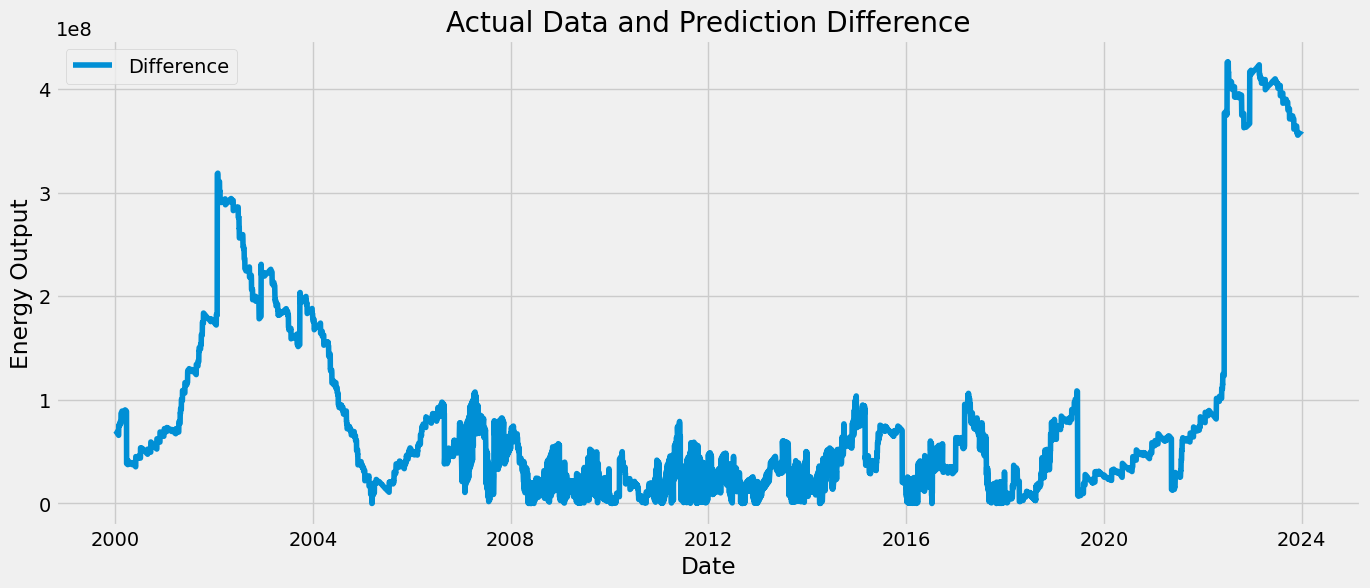

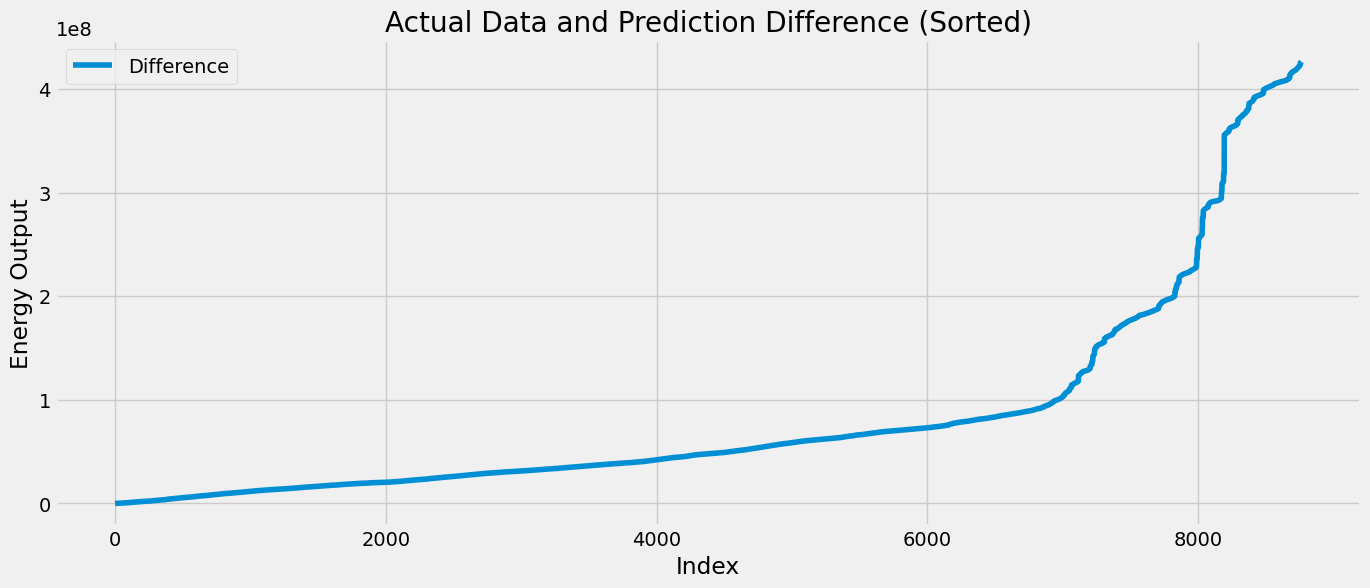

In [15]:
# Evaluation Difference

delta = np.abs(np.array(test["Budget"]) - np.array(test["Prediction"]))

plt.figure(figsize=(15, 6))
plt.plot(test.index, delta, label="Difference")
plt.xlabel("Date")
plt.ylabel("Energy Output")
plt.title("Actual Data and Prediction Difference")
plt.grid(True)
plt.legend()
plt.show()

sorted_delta = np.sort(delta)
plt.figure(figsize=(15, 6))
plt.plot(sorted_delta, label="Difference")
plt.xlabel("Index")
plt.ylabel("Energy Output")
plt.grid(True)
plt.legend()
plt.title("Actual Data and Prediction Difference (Sorted)")
plt.show()


In [16]:
# Analyzing Uncertainty

limit = np.sum(np.array(delta)) / ((1 + 5 ** 0.5) / 2) #Golden Ratio

temp = 0
i = 0
while temp < limit:
    temp += sorted_delta[i]
    i += 1

uncertainty = sorted_delta[i]

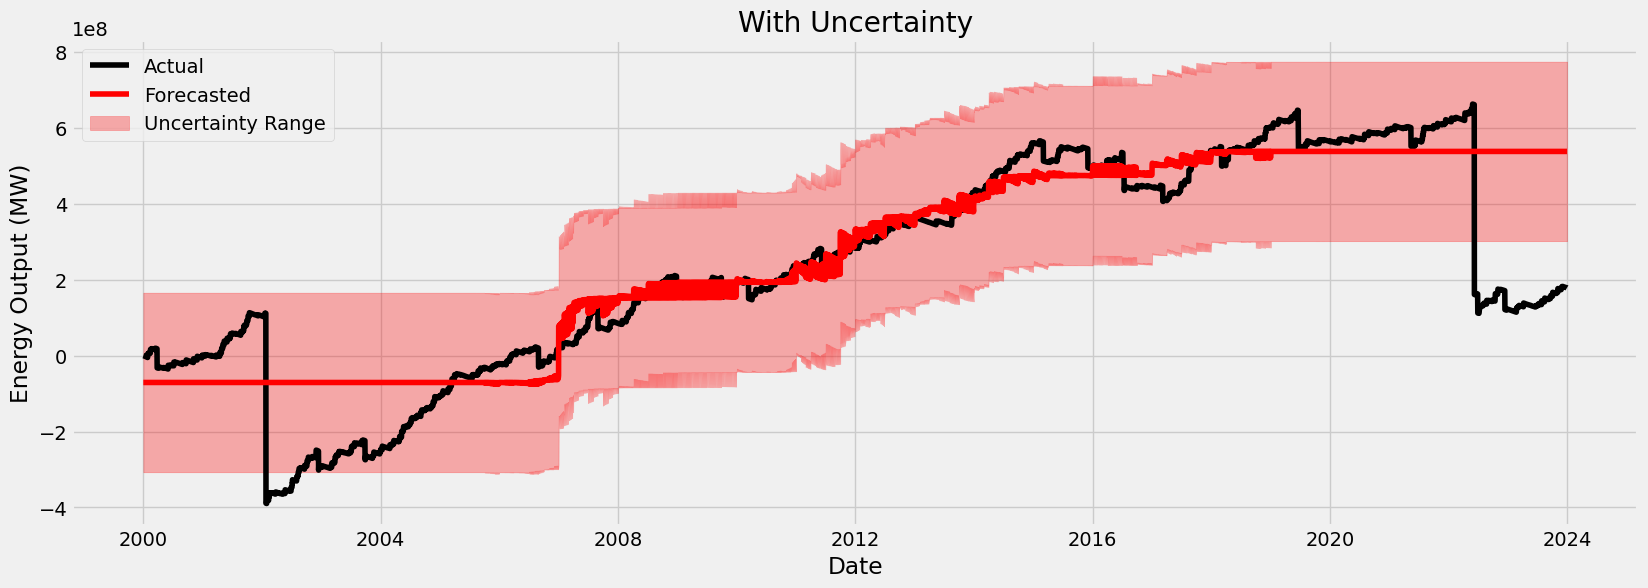

In [17]:
# Golden Ratio Uncertainty

predictions = np.array(predictions).flatten()

predictions_upper = predictions + uncertainty
predictions_lower = predictions - uncertainty

data_shown = 20000

fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df.index[-data_shown:], y_test[-data_shown:], label="Actual", color="black")
ax.plot(df.index[-data_shown:], predictions[-data_shown:], color="red", label="Forecasted")
ax.fill_between(df.index[-data_shown:], predictions_lower[-data_shown:], 
                predictions_upper[-data_shown:], 
                color="red", alpha=0.3, label="Uncertainty Range")
ax.set_title("With Uncertainty")
ax.set_xlabel("Date")
ax.set_ylabel("Energy Output (MW)")
ax.legend()
plt.grid(True)
plt.show()

100%|██████████| 8765/8765 [00:00<00:00, 17344.58it/s]


406119600.0


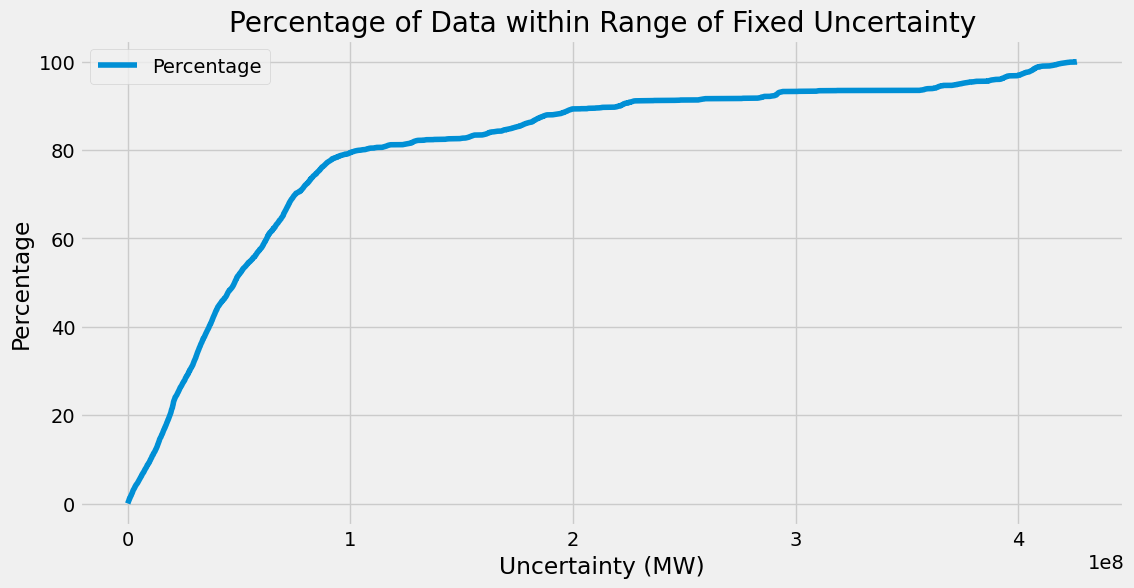

In [18]:
# Fixed Uncertainty

y_test = np.array(y_test).flatten()

fixed_uncertainty = []
isOK = False
FU = 0

for x in tqdm(sorted_delta):
    uncertainty = x

    predictions_upper = predictions + uncertainty
    predictions_lower = predictions - uncertainty

    within_range = np.sum((y_test >= predictions_lower) & (y_test <= predictions_upper))
    fixed_uncertainty.append((within_range / len(y_test)) * 100)

    if fixed_uncertainty[-1] > 98 and not isOK:
        FU = x
        print(FU)
        isOK = True

plt.figure(figsize=(12, 6))
plt.plot(sorted_delta, fixed_uncertainty, label="Percentage")
plt.legend()
plt.title("Percentage of Data within Range of Fixed Uncertainty")
plt.xlabel("Uncertainty (MW)")
plt.ylabel("Percentage")
plt.grid(True)
plt.show()

100%|██████████| 100/100 [00:00<00:00, 21767.11it/s]


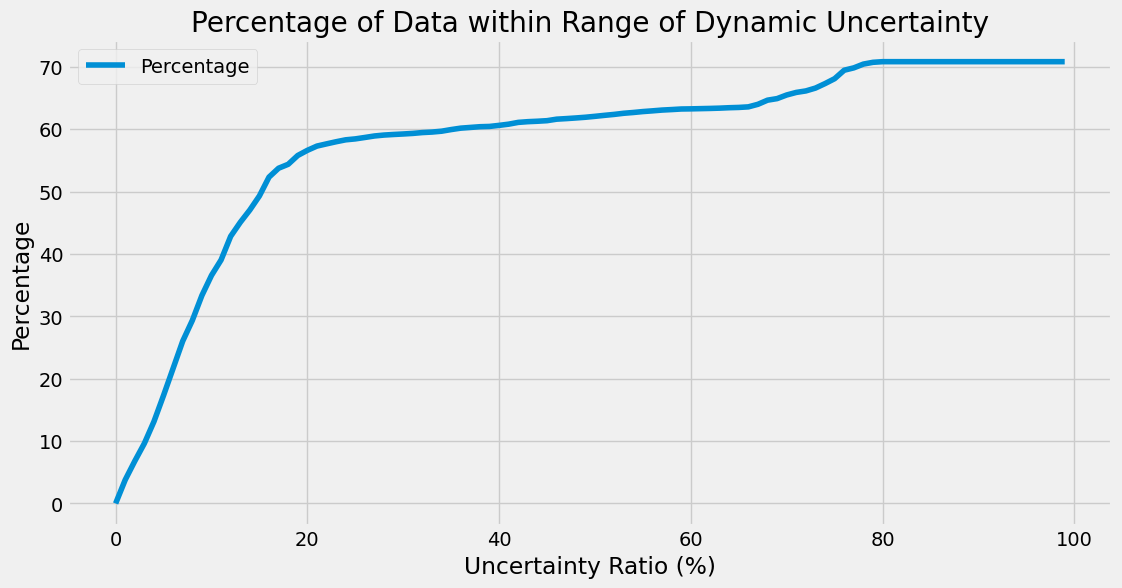

In [19]:
# Dynamic Uncertainty

dynamic_uncertainty = []
isOK = False
DU = 0

for ratio in tqdm(range(100)):
    uncertainty = predictions * (ratio / 100)

    predictions_upper = predictions + uncertainty
    predictions_lower = predictions - uncertainty

    within_range = np.sum((y_test >= predictions_lower) & (y_test <= predictions_upper))
    dynamic_uncertainty.append((within_range / len(y_test)) * 100)

    if dynamic_uncertainty[-1] > 98 and not isOK:
        DU = ratio
        print(DU)
        isOK = True

plt.figure(figsize=(12, 6))
plt.plot(np.arange(100), dynamic_uncertainty, label="Percentage")
plt.legend()
plt.title("Percentage of Data within Range of Dynamic Uncertainty")
plt.xlabel("Uncertainty Ratio (%)")
plt.ylabel("Percentage")
plt.grid(True)
plt.show()

In [20]:
# Creating Future Data

last_date = df.index[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 365 * 4 + 1)]

last_sequence = X_test[-1]

future = pd.DataFrame(index=future_dates, columns=TARGET + FEATURES)
future = create_features(future)

X_future = future[FEATURES]
y_future = future[TARGET]

X_future = scaler.transform(X_future)
X_future = X_future.reshape((X_future.shape[0], 1, X_future.shape[1]))

In [21]:
# Predict the future
future[TARGET] = model.predict(X_future)

future["F_UpperLimit"] = future[TARGET] + FU
future["F_LowerLimit"] = future[TARGET] - FU

future["D_UpperLimit"] = future[TARGET] * (1 + DU/100)
future["D_LowerLimit"] = future[TARGET] * (1 - DU/100)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


ValueError: Must pass 2-d input. shape=(1460, 1, 1)

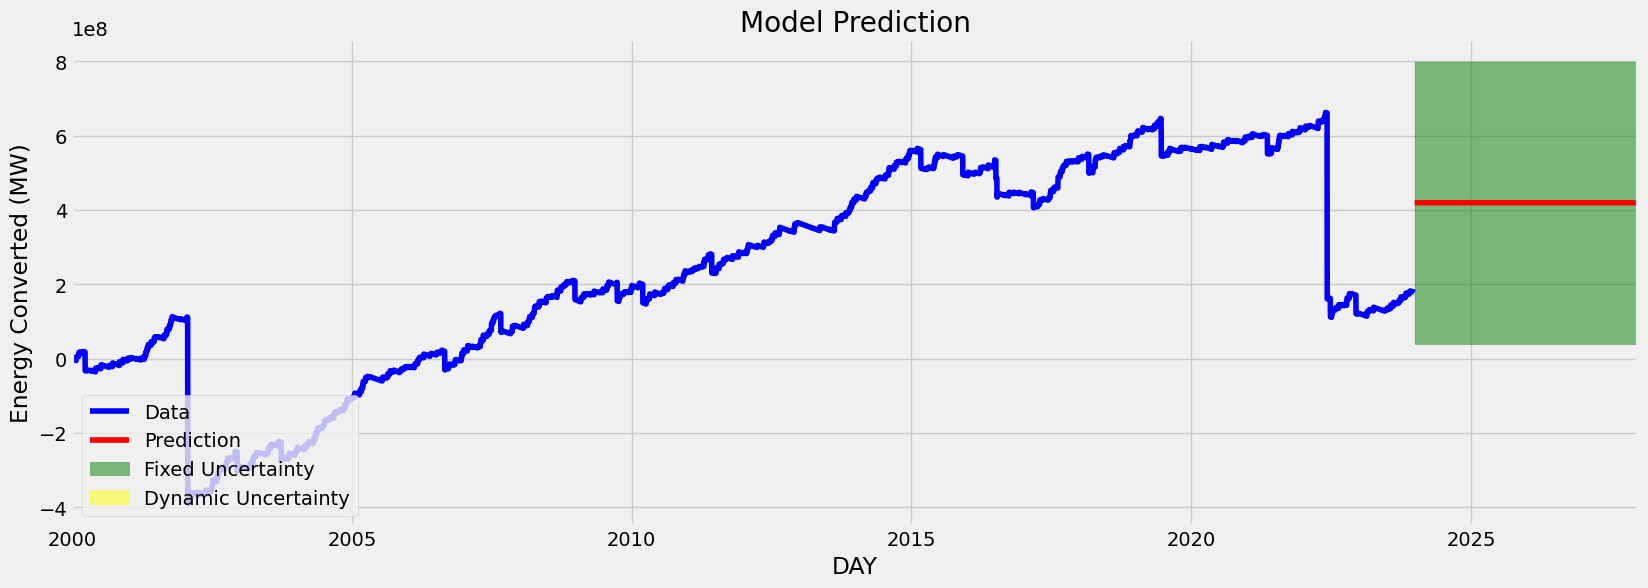

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
df[TARGET].plot(ax=ax, color="blue")
future[TARGET].plot(ax=ax, color="red")
ax.fill_between(future.index, 
                future['F_LowerLimit'], future['F_UpperLimit'],
                color='green', alpha=0.5)
ax.fill_between(future.index, future['D_LowerLimit'], 
                future['D_UpperLimit'],
                color='yellow', alpha=0.5)
ax.set_ylabel("Energy Converted (MW)")
ax.legend(["Data", "Prediction", "Fixed Uncertainty", "Dynamic Uncertainty"], loc='lower left')
plt.grid(True)
plt.title("Model Prediction")
plt.show()